# Clustering the users based on consupmtions

With great help from http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [38]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jqmcvi.base as jq
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from utils.data import load_all_users
from utils.data import distance_matrix

%matplotlib inline

In [193]:
data_path = '.exports/user_data_joined'

data = load_all_users(data_path, ['weekday', 'hour'], 'spotreba').as_matrix()

scaled_data = minmax_scale(data, axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'as_matrix'

In order to compute the silhouette index, we need to create the distance matrix:

In [7]:
%time scaled_dist_mat = distance_matrix(scaled_data, fastdtw.fastdtw)
%time dist_mat = distance_matrix(data, fastdtw.fastdtw)

Wall time: 2min 25s
Wall time: 2min 30s


In [86]:
def eval_agg_clust(clusterer, config, rang, distance, data):
    aggBouldins = []
    aggDunns = []
    aggSilhouette = []
    aggCalinskis = []
    
    for i in rang:
        config['n_clusters'] = i
        aggClusterer = clusterer(**config)
        aggClusterer.fit(data)

        clusters = []
        means = []
        for cluster_id in set(aggClusterer.labels_):
            cluster = data[np.argwhere(aggClusterer.labels_ == cluster_id)[:,0]]
            clusters.append(cluster)
            means.append(cluster.mean(axis=0))

        aggBouldins.append(jq.davisbouldin(clusters, means))
        aggDunns.append(jq.dunn_fast(data, aggClusterer.labels_))
        aggSilhouette.append(silhouette_score(distance, aggClusterer.labels_, metric='precomputed'))
        aggCalinskis.append(calinski_harabaz_score(data, aggClusterer.labels_))
    
    return aggBouldins, aggDunns, aggSilhouette, aggCalinskis

In [53]:
def plot_metrics(rang, bouldins, dunns, silhouettes, calinskis):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))

    ax1.plot(rang, bouldins)
    ax1.set_title('Davis-Bouldin index')
    ax2.plot(rang, dunns)
    ax2.set_title('Dunn index')
    ax3.plot(rang, silhouettes)
    ax3.set_title('Silhouette')
    ax4.plot(rang, calinskis)
    ax4.set_title('Calinski')

In [178]:
def plot_clusters(clusterer, config, data):
    clusterer = clusterer(**config)

    clusterer.fit(data)

    fig, axes = plt.subplots(config['n_clusters'], 1, figsize=(12,2*config['n_clusters']))


    for label in set(clusterer.labels_):
        cluster = data[np.argwhere(clusterer.labels_ == label)[:,0]].T
        axes[label].plot(cluster, c='#cccccc')
        axes[label].plot(cluster.mean(axis=1), c='r')
        axes[label].set_ylim(0, 6)
        axes[label].set_title('Number of instances: %d'%cluster.shape[1])
    plt.tight_layout()

In [104]:
RANG = range(2,11)

 # K-means

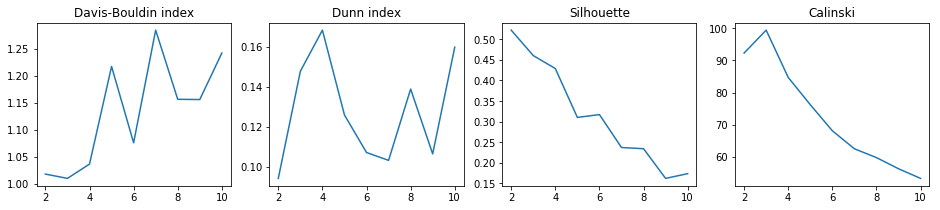

In [114]:
kmeans_config = { 'n_init': 20 }
metrics  = eval_agg_clust(KMeans, kmeans_config, RANG, dist_mat, data)

plot_metrics(RANG, *metrics)

Both Davis-Bouldin and Calinski-Harabaz suggest 3 as an optimal number of clusters, so let's plot them.

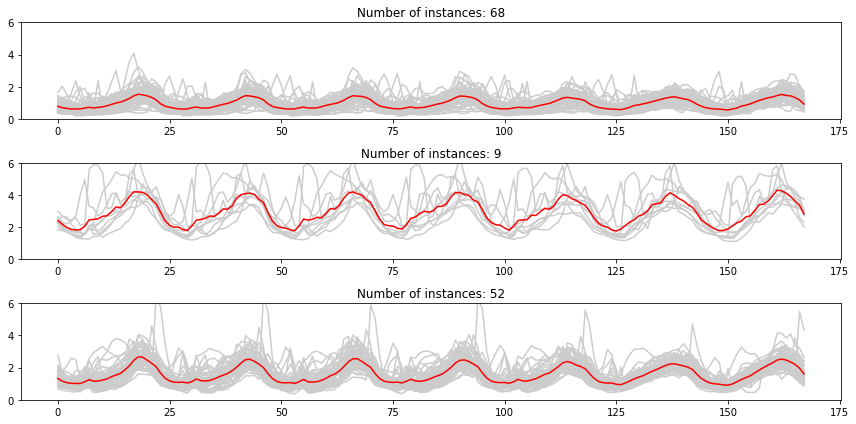

In [179]:
plot_clusters(KMeans, {'n_clusters': 3, 'n_init': 20}, data)

# Ward hierarchical clustering

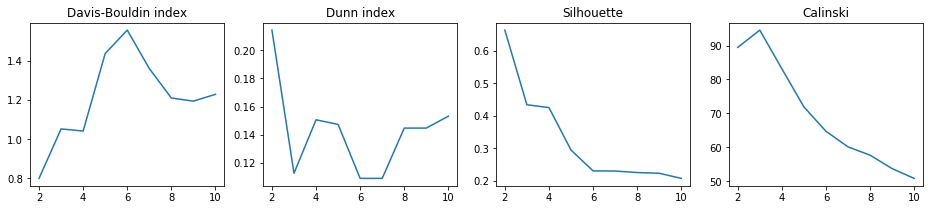

In [149]:
agg_config = {
    'linkage': 'ward'
}
metrics = eval_agg_clust(AgglomerativeClustering, agg_config, RANG, dist_mat, data)

plot_metrics(RANG, *metrics)


Here all metrics, except Calinski suggest 2 as an optimal number of cluster.

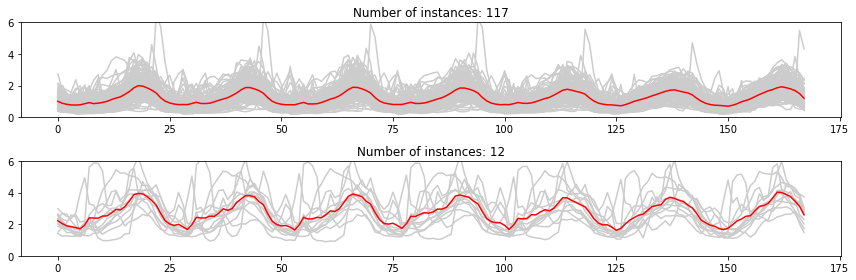

In [180]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 2, 'linkage': 'ward'}, data)

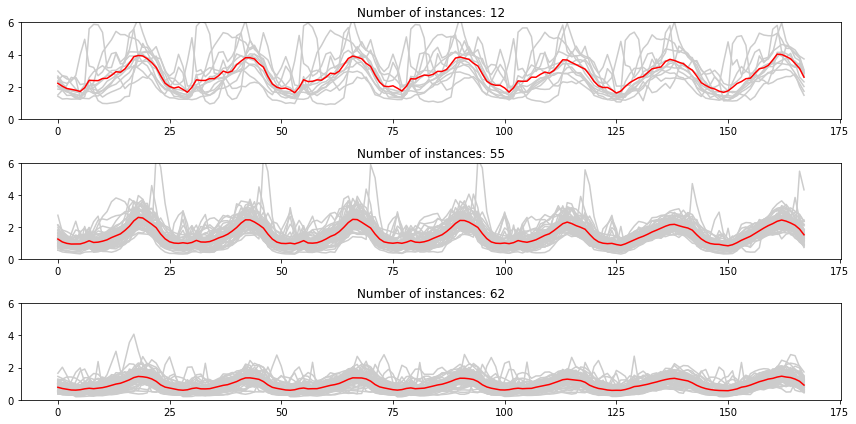

In [181]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 3, 'linkage': 'ward'}, data)

# Agglomerative clustering, complete linkage

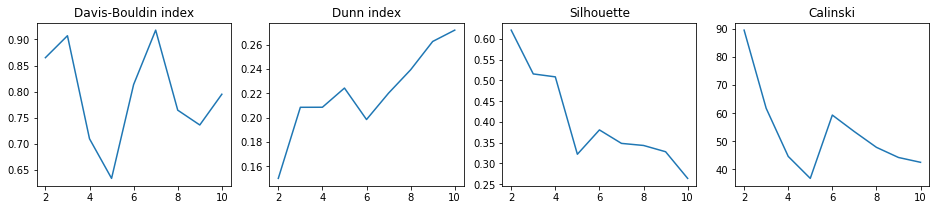

In [164]:
agg_config = {
    'linkage': 'complete'
}

metrics = eval_agg_clust(AgglomerativeClustering, agg_config, RANG, dist_mat, data)

plot_metrics(RANG, *metrics)

Here the Silhouette and Calinski suggest two cluster, however Davis-Bouldin suggest 5 and Dunn even 10 clusters. But as we will see, the latter two contain clusters with only one instance.

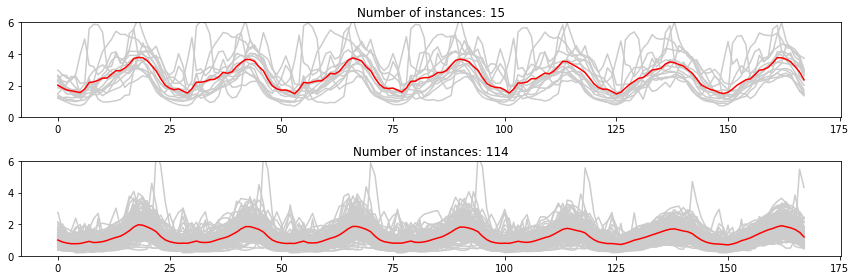

In [182]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 2, 'linkage': 'complete'}, data)

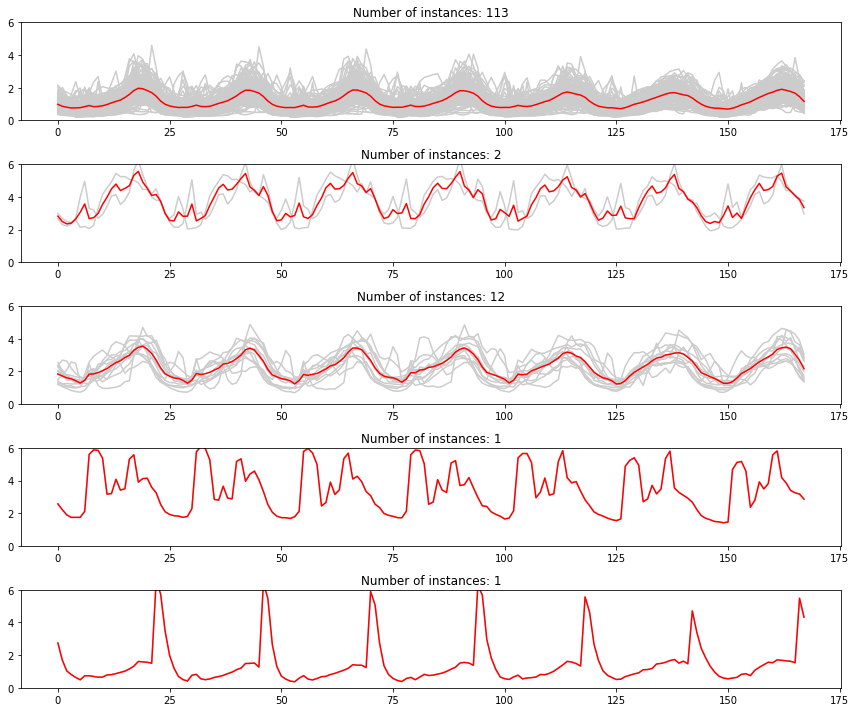

In [183]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 5, 'linkage': 'complete'}, data)

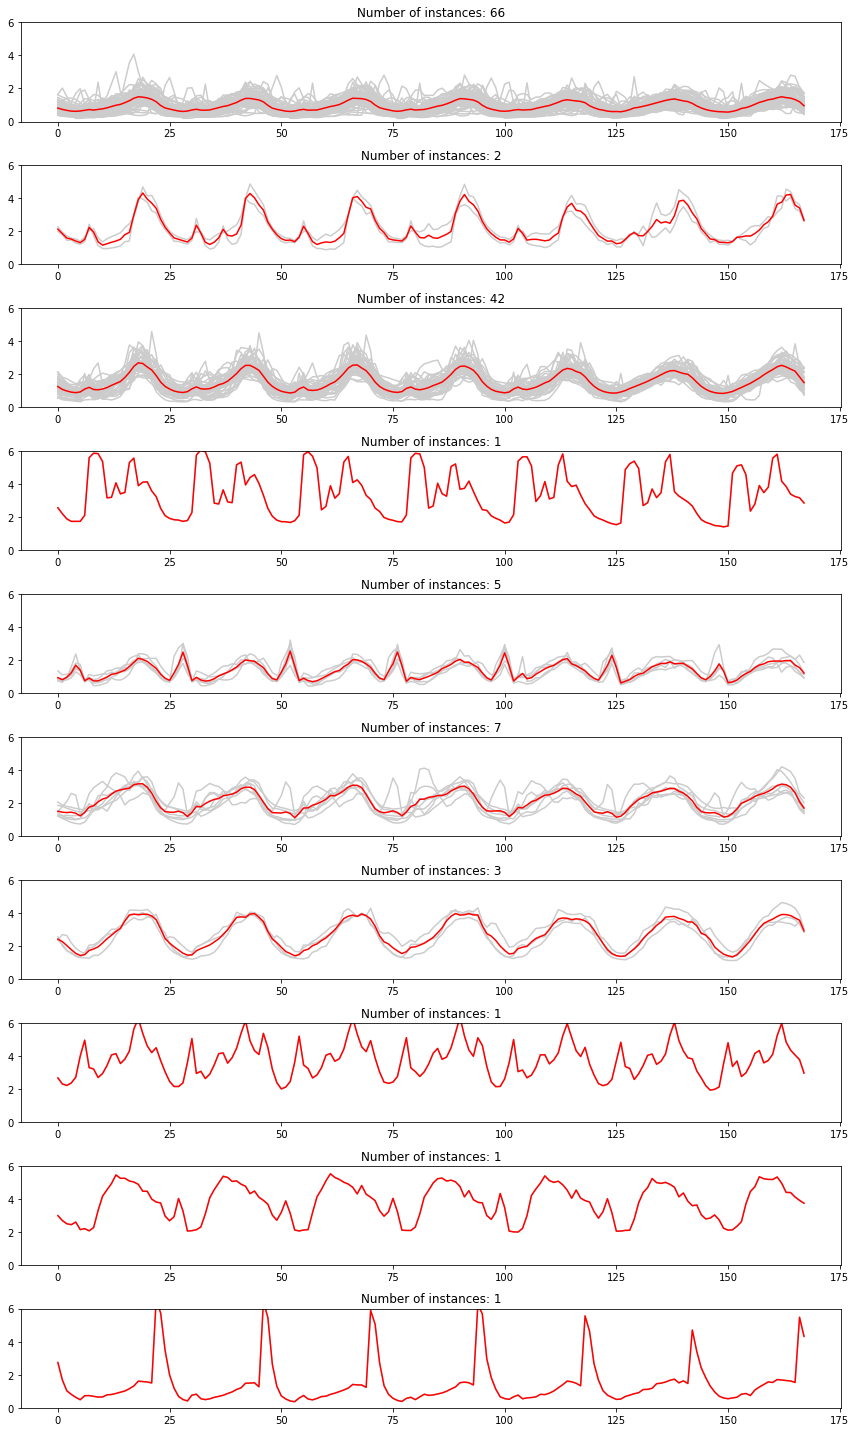

In [184]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 10, 'linkage': 'complete'}, data)

# Agglomerative clustering, average linkage

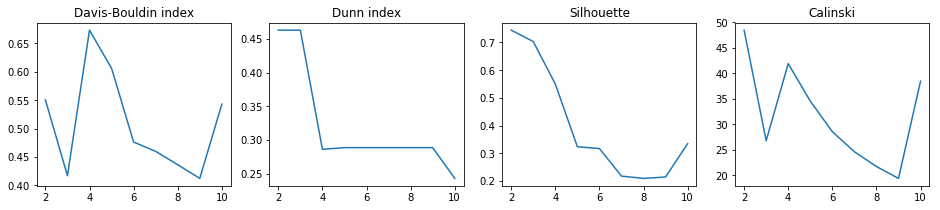

In [188]:
agg_config = {
    'linkage': 'average'
}

metrics = eval_agg_clust(AgglomerativeClustering, agg_config, RANG, dist_mat, data)

plot_metrics(RANG, *metrics)

Here the suggested amount are basically two and three clusters.

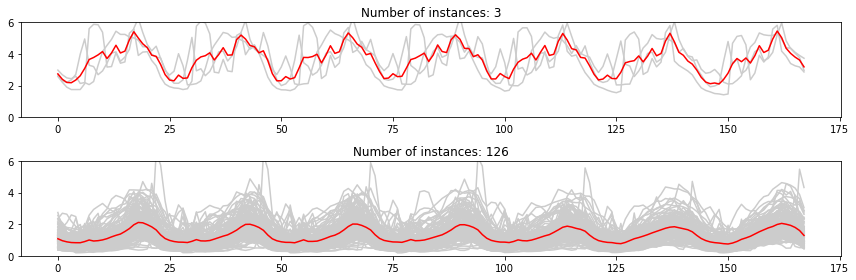

In [189]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 2, 'linkage': 'average'}, data)

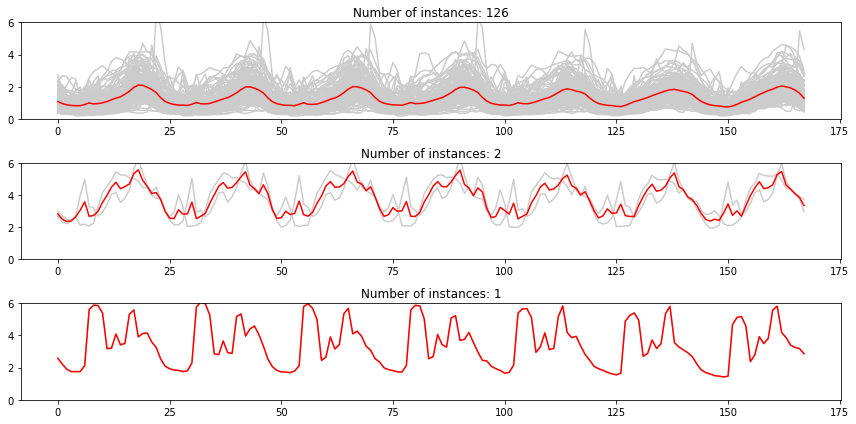

In [190]:
plot_clusters(AgglomerativeClustering, {'n_clusters': 3, 'linkage': 'average'}, data)

However, the resulting clusters are far from ideal, since there is a great imbalance between number of instances among each cluster.

-----------------

Best clustering from above experiments is provided by Ward Hierarchical clustering, so we are going to create groups of users based on this clustering.

In [191]:
clusterer = AgglomerativeClustering(**{'n_clusters': 3, 'linkage': 'ward'})

In [192]:
clusterer.fit(data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=3,
            pooling_func=<function mean at 0x000001F376A80840>)

In [195]:
all_data = load_all_users(data_path, ['year', 'month', 'day', 'hour'], 'spotreba')

In [200]:
means = []

for i in set(clusterer.labels_):
    cluster = all_data.iloc[np.argwhere(all_data.as_matrix() == i)[:,0]]
    means.append(cluster.mean(axis=0))

In [231]:
for label in set(clusterer.labels_):
    df = pd.DataFrame(columns=['year','month','day', 'consumption'])
    
    for i, value in means[label].items():
        row = {
            'year': i[0],
            'month': i[1],
            'day': i[2],
            'hour': i[3],
            'consumption': value
        }
        df = df.append(row, ignore_index=True)

    df.to_csv('.exports/clusters/%d.csv'%label)

Now we will also save the list of user ids

In [244]:
np.savetxt('.exports/clusters/assignments.csv', np.c_[range(0, clusterer.labels_.size), clusterer.labels_].astype(int), delimiter=',', fmt='%d')

In [239]:
 np.c_[range(0, clusterer.labels_.size), clusterer.labels_].astype(int)

array([[  0,   2],
       [  1,   1],
       [  2,   2],
       [  3,   2],
       [  4,   1],
       [  5,   2],
       [  6,   1],
       [  7,   1],
       [  8,   2],
       [  9,   1],
       [ 10,   2],
       [ 11,   2],
       [ 12,   2],
       [ 13,   1],
       [ 14,   0],
       [ 15,   1],
       [ 16,   1],
       [ 17,   2],
       [ 18,   1],
       [ 19,   2],
       [ 20,   2],
       [ 21,   2],
       [ 22,   0],
       [ 23,   1],
       [ 24,   1],
       [ 25,   1],
       [ 26,   2],
       [ 27,   2],
       [ 28,   1],
       [ 29,   2],
       [ 30,   1],
       [ 31,   2],
       [ 32,   1],
       [ 33,   2],
       [ 34,   2],
       [ 35,   0],
       [ 36,   2],
       [ 37,   2],
       [ 38,   1],
       [ 39,   2],
       [ 40,   2],
       [ 41,   2],
       [ 42,   2],
       [ 43,   1],
       [ 44,   1],
       [ 45,   1],
       [ 46,   2],
       [ 47,   2],
       [ 48,   0],
       [ 49,   2],
       [ 50,   1],
       [ 51,   2],
       [ 52,